In [4]:
import sys
import os
import math

sys.path.append('cryoem/')
sys.path.append('cryoem/util')

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

In [21]:
def read_theoretical(path):
    # Read the theoretical starfile
    # We only want (1-indexed): 2 (psi), 3 (phi), 4 (theta), 12 (originX), 13 (originY) 
    # BEWARE skiprows, starfile header lengths may vary
    theoretical = pd.read_csv(path, delim_whitespace=True, header=None, skiprows=21)
    theoretical = theoretical[theoretical.columns[[1, 2, 3, 11, 12]]]
    theoretical.columns = [ 'psi', 'phi', 'theta', 'shiftX', 'shiftY']
    theoretical = theoretical.astype(float)
#     theoretical['quaternion'] = theoretical.apply(lambda row: euler2quat(row.phi*np.pi/180, row.theta*np.pi/180, row.psi*np.pi/180), axis=1)
    return theoretical

In [8]:
def read_experimental(path):
    # Read the experimental parfile
    # BEWARE dropping last two rows.
    experimental = pd.read_csv(path, delim_whitespace=True)
    experimental = experimental[experimental.columns[[1, 3, 2, 4, 5]]]
    experimental.columns = [ 'psi', 'phi', 'theta', 'shiftX', 'shiftY']
    experimental.drop(experimental.tail(2).index,inplace=True)
    experimental = experimental.astype(float)
#     experimental['quaternion'] = experimental.apply(lambda row: euler2quat(row.phi*np.pi/180, row.theta*np.pi/180, row.psi*np.pi/180), axis=1)
    return experimental

In [244]:
which = '5'

# Read the data
print('Reading theoretical data...')
temet_theoretical = read_theoretical('alignment_data/temet_' + which + '.star')
wt_theoretical = read_theoretical('alignment_data/wt_' + which + '.star')
print('Reading experimental data...')
temet_experimental = read_experimental('alignment_data/temet_' + which + '.par')
wt_experimental = read_experimental('alignment_data/wt_' + which + '.par')

EmptyDataError: No columns to parse from file

In [242]:
# Euler angles to Quaternion (from https://github.com/asarnow/pyem geom.py)
def euler2quat(alpha, beta, gamma):
    ha, hb, hg = alpha / 2, beta / 2, gamma / 2
    ha_p_hg = ha + hg
    hg_m_ha = hg - ha
    q = np.array([np.cos(ha_p_hg) * np.cos(hb),
                  np.sin(hg_m_ha) * np.sin(hb),
                  np.cos(hg_m_ha) * np.sin(hb),
                  np.sin(ha_p_hg) * np.cos(hb)])
    return q

# Quaternion to Euler Angles (from https://github.com/asarnow/pyem geom.py)
def quat2euler(q):
    ha1 = np.arctan2(q[1], q[2])
    ha2 = np.arctan2(q[3], q[0])
    alpha = ha2 - ha1  # np.arctan2(r21/r20)
    beta = 2 * np.arccos(np.sqrt(q[0]**2 + q[3]**2))  # np.arccos*r33
    gamma = ha1 + ha2  # np.arctan2(r12/-r02)
    return alpha, beta, gamma

# Angular distance between two quaternions
def quatDist(a,b):
    # Check to verify that quaternions are unit lengths
    assert abs(math.sqrt(a[0]**2+a[1]**2+a[2]**2+a[3]**2)-1)<.001,"a is not a unit quaternion"
    assert abs(math.sqrt(b[0]**2+b[1]**2+b[2]**2+b[3]**2)-1)<.001,"b is not a unit quaternion"
    
    # Compute distance
    s = a[0]*b[0] + a[1]*b[1] + a[2]*b[2] + a[3]*b[3]
    s = 2*(s**2)-1
    return np.arccos(s)*180/np.pi

# Given two ordered lists of quaternions, compute distances between each angle
def computeAngleErrors(A, B):
    qq = zip(A, B)
    errors = []
    for i,v in enumerate(qq):
        dist = quatDist(v[0],v[1])
        errors.append((dist))

    return errors

# A and B are (x,y) tuples
def euclideanDistance(A,B):
    return math.sqrt((A[0]-B[0])**2 + (A[1]-B[1])**2)

# theoretical and experimental are arrays of (x,y) tuples
def computeShiftErrors(theoretical, experimental):
    ab = zip(theoretical, experimental)
    errors = []
    for i, v in enumerate(ab):
        dist = euclideanDistance(v[0],v[1])
        errors.append(dist)
    return errors

def mean(array):
    return sum(array)/len(array)

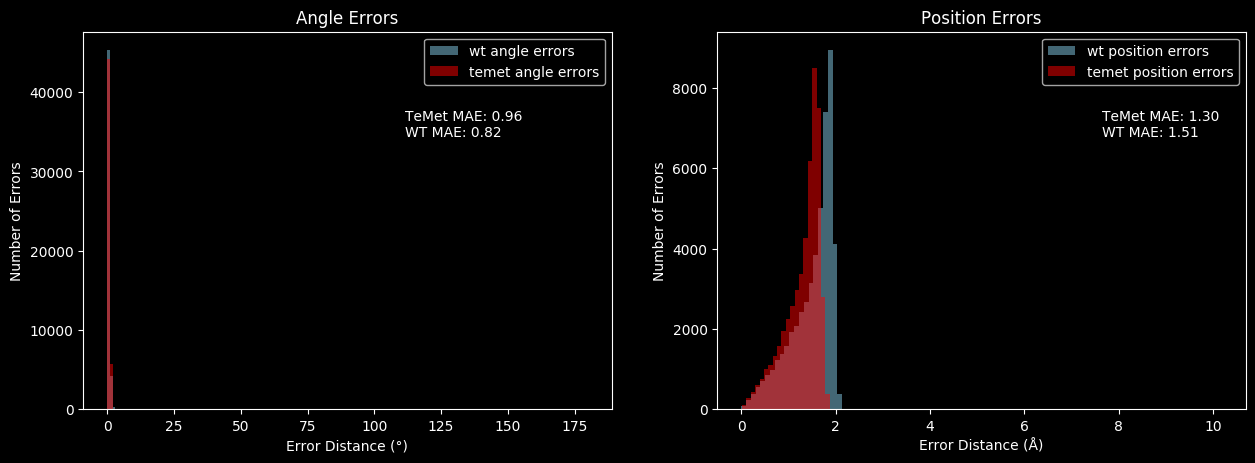

In [243]:
# Compute angle errors
print('computing angular errors...')
wt_angle_errors = computeAngleErrors(wt_theoretical.quaternion, wt_experimental.quaternion)
temet_angle_errors = computeAngleErrors(temet_theoretical.quaternion, temet_experimental.quaternion)

wt_angle_mae = mean(wt_angle_errors)
temet_angle_me = mean(temet_angle_errors)

# Compute position errors
print('computing positional errors...')
wt_theoretical_shifts = zip(wt_theoretical.shiftX, wt_theoretical.shiftY)
wt_experimental_shifts = zip(wt_experimental.shiftX, wt_experimental.shiftY)

temet_theoretical_shifts = zip(temet_theoretical.shiftX, temet_theoretical.shiftY)
temet_experimental_shifts = zip(temet_experimental.shiftX, temet_experimental.shiftY)

wt_position_errors = computeShiftErrors(wt_theoretical_shifts,wt_experimental_shifts)
temet_position_errors = computeShiftErrors(temet_theoretical_shifts,temet_experimental_shifts)

wt_position_mae = mean(wt_position_errors)
temet_position_mae = mean(temet_position_errors)

print('plotting...')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Plot angle errors
ax1.hist((wt_angle_errors), bins=180, alpha=0.5, color='skyblue', label='wt angle errors');
ax1.hist((temet_angle_errors), bins=180, alpha=0.5,color='red', label='temet angle errors');
ax1.title.set_text('Angle Errors')
ax1.set_xlabel("Error Distance (°)")
ax1.set_ylabel("Number of Errors")
ax1.text(0.1,0.7,"TeMet MAE: %.2f \nWT MAE: %.2f" % (temet_angle_me, wt_angle_mae),transform=ax.transAxes)
ax1.legend()

# Plot position errors
ax2.hist((wt_position_errors), bins=100, alpha=0.5, color='skyblue', label='wt position errors');
ax2.hist((temet_position_errors), bins=100, alpha=0.5,color='red', label='temet position errors');
ax2.title.set_text('Position Errors')
ax2.set_xlabel("Error Distance (Å)")
ax2.set_ylabel("Number of Errors")
ax2.text(.55,0.7,"TeMet MAE: %.2f \nWT MAE: %.2f" % (temet_position_mae, wt_position_mae),transform=ax.transAxes)

ax2.legend()
plt.savefig('errors.png')
plt.show()

print('done!!!')


In [22]:
t = read_experimental('../alignment_data/temet_30.par')
c = read_experimental('../alignment_data/temet_20.par')
h = read_theoretical('../alignment_data/temet_30.star')

In [28]:
h

,psi,phi,theta,shiftX,shiftY
0,324.234505,-151.065650,31.367249,0.0,0.0
1,49.131174,103.242403,91.947730,0.0,0.0
2,173.716859,-166.748253,67.415090,0.0,0.0
3,37.250014,157.562733,57.698695,0.0,0.0
4,136.001695,-84.903875,147.861491,0.0,0.0
...,...,...,...,...,...
49995,317.275166,97.273672,17.467007,0.0,0.0
49996,159.426500,-101.431044,27.596672,0.0,0.0
49997,182.372561,39.911549,77.679143,0.0,0.0
49998,114.432440,160.821772,42.242015,0.0,0.0


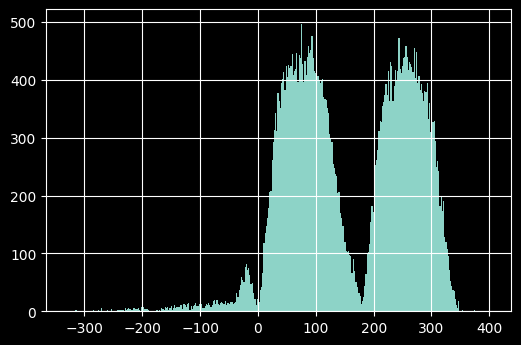

In [19]:
c.theta.hist(bins=360)